In [1]:
!pip install qiskit --quiet
!pip install qiskit-machine-learning --quiet
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=c7c21e46d030f1a96c3b0aac70f1aecbf9839ce7d79917b16638480ec14379dc
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Any, Optional, cast, Union

import torch
from torch.utils.data import DataLoader
from torch.nn import Module, Linear, Softmax
from torchvision import datasets, transforms
from torch import cat, no_grad, manual_seed
from torch import optim
from torch.nn import NLLLoss
from torch.utils.data import random_split
from torch.autograd import Variable

from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit, Aer
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.opflow import I, X, Y, Z, StateFn,ListOp
from qiskit.opflow import AerPauliExpectation
from qiskit.utils import QuantumInstance

## Dataset

In [3]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 32
n_samples = 150  # We will concentrate on the first 200 samples
num_workers = 2

val_size = 100
train_size = 2*n_samples - val_size

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.CenterCrop((20,20)),
                                                                            transforms.Resize((8,8)),
                                                                            transforms.Normalize((0.1307,), (0.3081,))])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)


X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_ds, val_ds = random_split(X_train, [train_size, val_size])

# Define torch dataloader with filtered data
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



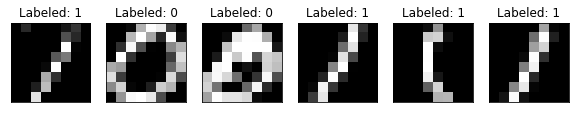

In [4]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [5]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),
                                                                             transforms.CenterCrop((20,20)),
                                                                             transforms.Resize((8,8)),
                                                                             transforms.Normalize((0.1307,), (0.3081,))])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## QLayers

In [6]:
def generate_circuit(n_qubits, n_layers, n_inputs):
    
    all_qubits = [i for i in range(n_qubits)]
    
    w = ParameterVector('w', length= n_layers*n_qubits*n_inputs)
    w = np.asarray(w).reshape((n_layers, n_qubits, n_inputs))
    
    b = ParameterVector('b', length= n_layers*n_qubits)
    b = np.asarray(b).reshape((n_layers, n_qubits))

    in_theta = ParameterVector('x', length=n_inputs)
    in_theta = np.asarray(in_theta).reshape((n_inputs))
    
    circuit = QuantumCircuit(n_qubits)
    circuit.h(all_qubits)

    for l in range(n_layers):
        for q in all_qubits:
            circuit.ry(np.dot(w[l][q], in_theta) + b[l][q], q)
        if (l & 1):
            for q0, q1 in zip(all_qubits[1::2], all_qubits[2::2] + [all_qubits[0]]):
                circuit.cz(q0,q1)
        else:
            for q0, q1 in zip(all_qubits[0::2], all_qubits[1::2]):                 
                circuit.cz(q0,q1)
                
    return circuit, list(w.flat), list(b.flat), list(in_theta.flat)

In [7]:
class QConv2D(TorchConnector):
    def __init__(self, kernel_size=(3,3), strides=(2,2), n_qubits = 1, n_layers = 1):
        
        qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
        
        self.kernel_size = kernel_size
        self.strides = strides
        n_inputs = np.prod(kernel_size)
        
        self.circuit, w, b, in_theta = generate_circuit(n_qubits, n_layers, n_inputs)
        self.observables = ListOp([Z])
        
        self.operator = ~StateFn(self.observables) @ StateFn(self.circuit)
        
        self.circuit_operator = OpflowQNN(self.operator,
                                          input_params= in_theta ,
                                          weight_params= w + b,
                                          input_gradients=True,
                                          exp_val = AerPauliExpectation(),
                                          quantum_instance=qi)
        super(QConv2D, self).__init__(self.circuit_operator)
    
    def forward(self, input_data: Optional[torch.Tensor] = None) -> torch.Tensor:
        
        k = self.kernel_size
        s = self.strides
        
        iter_x = int((input_data.shape[2] - k[0]) / s[0] + 1)
        iter_y = int((input_data.shape[3] - k[1]) / s[1] + 1)
        
        out = []
        for i in range(iter_x):
            for j in range(iter_y):
                _x = input_data[:,0, i*s[0]:i*s[0] + k[0], j*s[1]:j*s[1] + k[1]]
                _x = _x.flatten(start_dim = 1)
                out+= [TorchConnector._TorchNNFunction.apply(_x, 
                                                             self._weights, 
                                                             self._neural_network, 
                                                             self._sparse)]
        out = torch.cat(out,-1)
        out = torch.reshape(out,(-1,1, iter_x,iter_y))
        return out

In [8]:
class QLinear(TorchConnector):
    def __init__(self, n_inputs, n_qubits = 1, n_layers = 1):
        
        qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
        
        self.circuit, w, b, in_theta = generate_circuit(n_qubits, n_layers, n_inputs)
        self.observables = ListOp([Z])
        
        self.operator = ~StateFn(self.observables) @ StateFn(self.circuit)
        
        self.circuit_operator = OpflowQNN(self.operator,
                                          input_params= in_theta ,
                                          weight_params= w + b,
                                          input_gradients=True,
                                          exp_val = AerPauliExpectation(),
                                          quantum_instance=qi)
        super(QLinear, self).__init__(self.circuit_operator)
    
    def forward(self, input_data: Optional[torch.Tensor] = None) -> torch.Tensor:
        _x = input_data.flatten(start_dim = 1)
        out = TorchConnector._TorchNNFunction.apply(_x, 
                                                     self._weights, 
                                                     self._neural_network, 
                                                     self._sparse)
        return out

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Hybrid

In [10]:
class HybridModel(Module):
    def __init__(self):
        super().__init__()
        self.qlayer_1 = QConv2D(n_qubits = 1, n_layers = 1)
        self.clayer_1 = Linear(9,2)
        self.softmax = Softmax(dim=1)
        self.loss_func = NLLLoss()

    def forward(self, x):
        x = self.qlayer_1(x)
        x = x.flatten(start_dim = 1)
        x = self.clayer_1(x)
        return self.softmax(x)
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.loss_func(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.loss_func(out, labels)    # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [11]:
model = HybridModel()

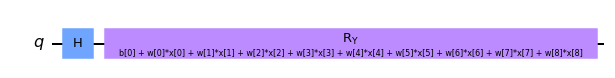

In [12]:
model.qlayer_1.circuit.draw('mpl')

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [14]:
device = get_default_device()
device

device(type='cpu')

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [16]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [18]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
to_device(model, device)

HybridModel(
  (qlayer_1): QConv2D()
  (clayer_1): Linear(in_features=9, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (loss_func): NLLLoss()
)

In [20]:
history = fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: -0.7459, val_acc: 0.8203
Epoch [1], val_loss: -0.8738, val_acc: 0.9062
Epoch [2], val_loss: -0.9614, val_acc: 0.9844
Epoch [3], val_loss: -0.9725, val_acc: 0.9844
Epoch [4], val_loss: -0.9756, val_acc: 0.9922
Epoch [5], val_loss: -0.9803, val_acc: 0.9922
Epoch [6], val_loss: -0.9822, val_acc: 0.9922
Epoch [7], val_loss: -0.9829, val_acc: 0.9922
Epoch [8], val_loss: -0.9837, val_acc: 0.9844
Epoch [9], val_loss: -0.9831, val_acc: 0.9844


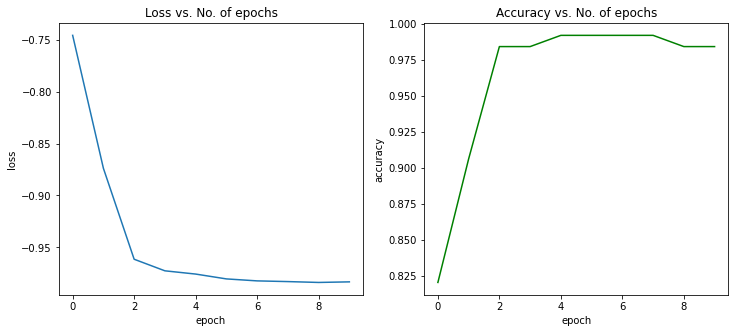

In [21]:
losses = [x['val_loss'] for x in history]
accuracies = [x['val_acc'] for x in history]

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(losses)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Loss vs. No. of epochs');

ax[1].plot(accuracies,color='green')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Accuracy vs. No. of epochs');

In [22]:
torch.save(model.state_dict(), "model.pt")

In [23]:
model = HybridModel()
model.load_state_dict(torch.load("model.pt"))
to_device(model, device)

HybridModel(
  (qlayer_1): QConv2D()
  (clayer_1): Linear(in_features=9, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (loss_func): NLLLoss()
)

In [24]:
history = [evaluate(model, test_loader)]
history

[{'val_loss': -0.9937375783920288, 'val_acc': 0.9921875}]

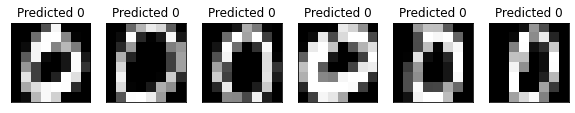

In [33]:
n_samples_show = 6
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    x, y = next(iter(test_loader))
    output = model(x[:n_samples_show])
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)
    pred = output.argmax(dim=1, keepdim=True)

    for count in range(n_samples_show):
        axes[count].imshow(data[count].numpy().squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred[count].item()))


## Fully Quantum

In [34]:
class QCNN(Module):
    def __init__(self):
        super().__init__()
        self.qlayer_1 = QConv2D(n_qubits = 1, n_layers = 1)
        self.qlayer_2 = QLinear(n_inputs = 9, n_qubits = 1, n_layers = 1)
        self.loss_func = NLLLoss()

    def forward(self, x):
        x = self.qlayer_1(x)
        x = x.flatten(start_dim = 1)
        x = self.qlayer_2(x)
        x = (x + 1)/2
        return cat((x, 1 - x), -1)
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.loss_func(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.loss_func(out, labels)    # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [35]:
model = QCNN()

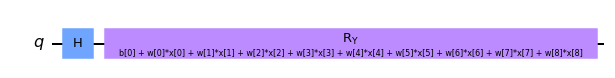

In [36]:
model.qlayer_1.circuit.draw('mpl')

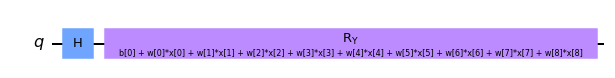

In [37]:
model.qlayer_2.circuit.draw('mpl')

In [38]:
to_device(model, device)

QCNN(
  (qlayer_1): QConv2D()
  (qlayer_2): QLinear()
  (loss_func): NLLLoss()
)

In [39]:
history = fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: -0.6880, val_acc: 0.7422
Epoch [1], val_loss: -0.7493, val_acc: 0.7891
Epoch [2], val_loss: -0.8443, val_acc: 0.8672
Epoch [3], val_loss: -0.8584, val_acc: 0.8984
Epoch [4], val_loss: -0.8718, val_acc: 0.8906
Epoch [5], val_loss: -0.8388, val_acc: 0.8438
Epoch [6], val_loss: -0.8891, val_acc: 0.9141
Epoch [7], val_loss: -0.8878, val_acc: 0.9297
Epoch [8], val_loss: -0.9030, val_acc: 0.9375
Epoch [9], val_loss: -0.8906, val_acc: 0.9531


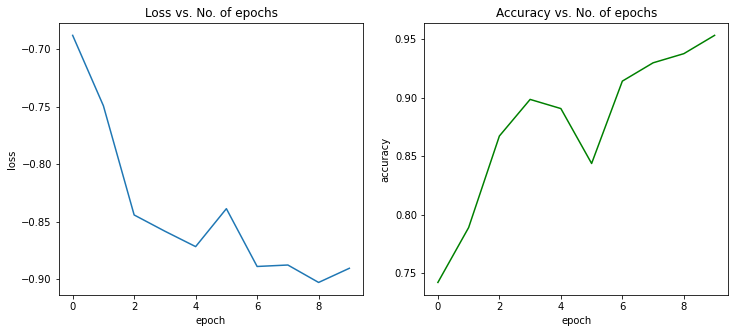

In [40]:
losses = [x['val_loss'] for x in history]
accuracies = [x['val_acc'] for x in history]

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(losses)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Loss vs. No. of epochs');

ax[1].plot(accuracies,color='green')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Accuracy vs. No. of epochs');

In [41]:
history = [evaluate(model, test_loader)]
history

[{'val_loss': -0.9056794047355652, 'val_acc': 0.953125}]

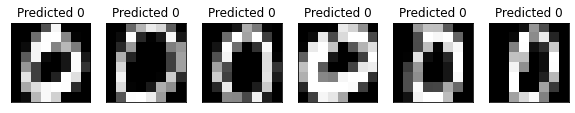

In [42]:
n_samples_show = 6
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    x, y = next(iter(test_loader))
    output = model(x[:n_samples_show])
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)
    pred = output.argmax(dim=1, keepdim=True)

    for count in range(n_samples_show):
        axes[count].imshow(data[count].numpy().squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred[count].item()))
